# Importo librerias

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit
from scipy.stats import chi2
import pandas as pd

Algunas configuraciones globales:

In [108]:
dir_drive = '' # --> Colocar carpeta del drive

#------Tamaño de letra en los ejes----------
plt.rcParams['xtick.labelsize'] = 14  # tamaño de los números del eje x
plt.rcParams['ytick.labelsize'] = 14  # tamaño de los números del eje y

# Cargado de archivos

In [109]:
c = 3e8 #m/s
X, Y, V, nu = [], [], [], [] # --> Cada elemento de la lista corresponde a los datos de una longitud de onda

folder = dir_drive + 'Mediciones/Barrido voltaje dia 3'
fname = os.listdir(folder + '/')
files = fname[:9] + fname[-5:] # --> contiene primeras mediciones y los alts
for file in files:
    root = folder + '/' + file
    if file[:7] == 'barrido':
        medXYV = np.genfromtxt(root, delimiter = ',')
        N = len(medXYV)
        Xi, Yi, Vi = np.zeros(N - 1), np.zeros(N - 1), np.zeros(N - 1)
        for i, row in enumerate(medXYV[1:]):
            Xi[i], Yi[i], Vi[i] = row[0], row[1], row[2]
        X.append(Xi), Y.append(Yi), V.append(Vi)
        lamb = float(file[-9:-6])*1e-9 #m
        nu.append(c / lamb)

# Cálculo de $I$ y $V_0$

In [110]:
# Obtengo el V / I = 0
def V0min(x, v, epsilon = .05e-10, p = -1):
    xc = x[(x >= 0) & (x <= epsilon)]
    vc = v[(x >= 0) & (x <= epsilon)]

    xc0, vc0, ind_vc0 = xc[p], vc[p], np.where(v == vc[p])[0]
    err_vc0 = np.max([vc0 - v[ind_vc0 - 1], v[ind_vc0 + 1] - vc0])
    
    return xc0, vc0, err_vc0

def rectas(I, V):
    #--------Recorto datos para ajuste---------
    I_corte0, V_corte0 = I[10:30], V[10:30]
    I_corte1, V_corte1 = I[(V >= 0) & (V <= .5)], V[(V >= 0) & (V <= .5)]

    #--------Ajuste---------
    lin = lambda x, a, b: a*x + b
    popt0, pcov0 = curve_fit(lin, V_corte0, I_corte0) # --> Línea naranja
    popt1, pcov1 = curve_fit(lin, V_corte1, I_corte1) # --> Línea roja
    m, b = popt0
    m_, b_ = popt1
    
    #--------------------------
    # Buscamos la interseccion
    #--------------------------
    dm, db = (b - b_) / (m_ - m)**2, 1 / (m_ - m)
    dm_, db_ = -dm, -db
    
    V0_comun = (b_ - b) / (m - m_)
    var_v0_comun = dm**2 * ( pcov0[0][0] + pcov1[0][0] ) + 2*dm*db * ( pcov0[0][1] + pcov1[0][1]) + db**2 * ( pcov0[1][1] + pcov1[1][1] )

    return popt0, popt1, V0_comun, np.sqrt(var_v0_comun)


# Gráficos de las mediciones

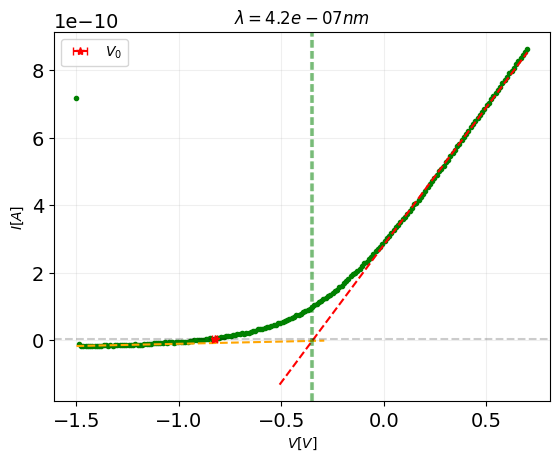

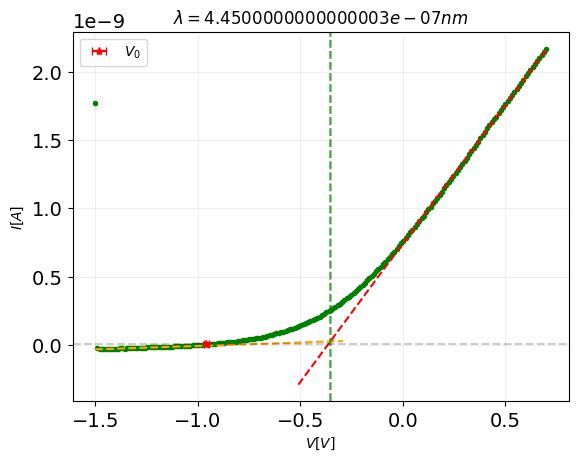

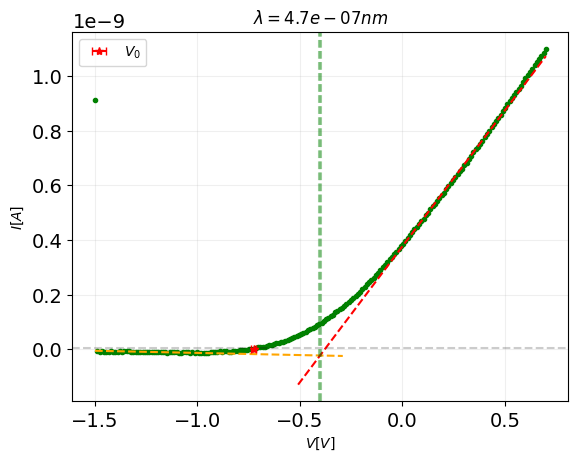

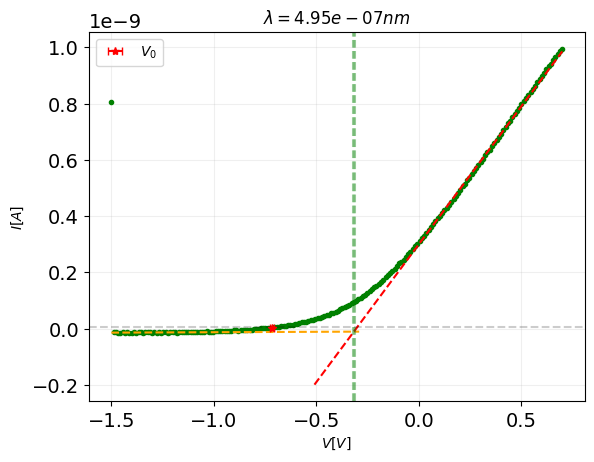

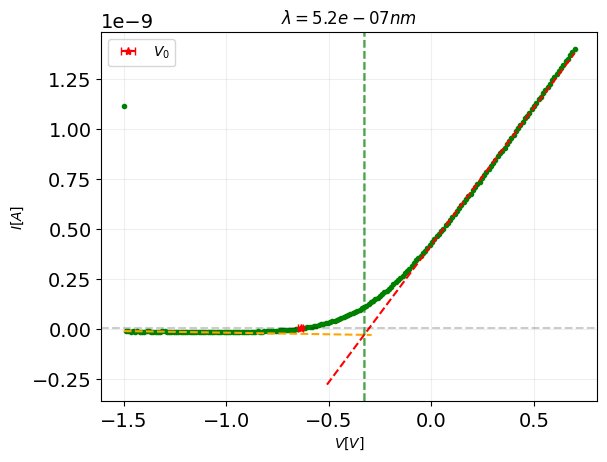

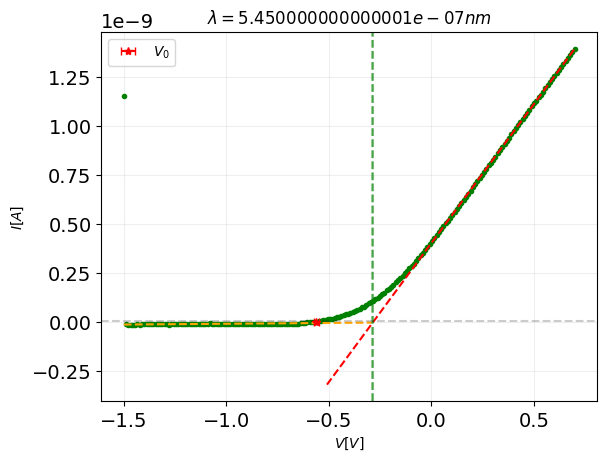

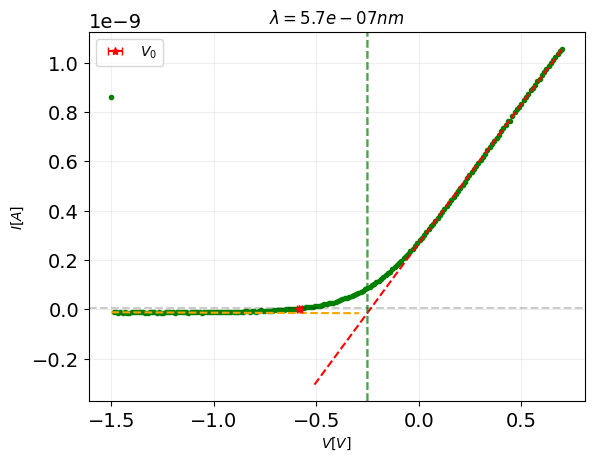

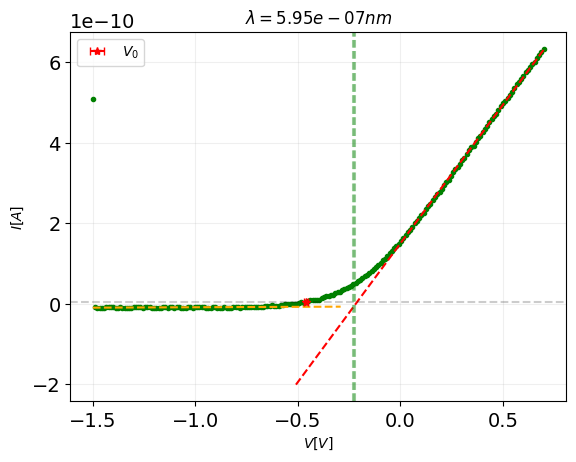

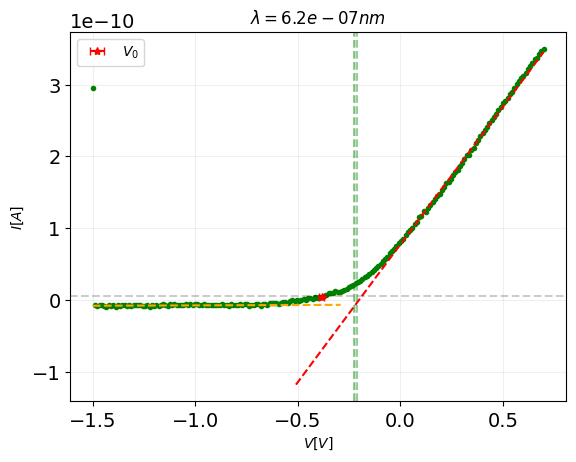

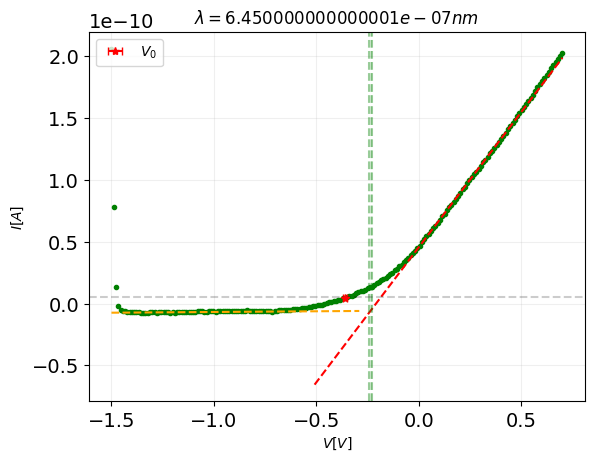

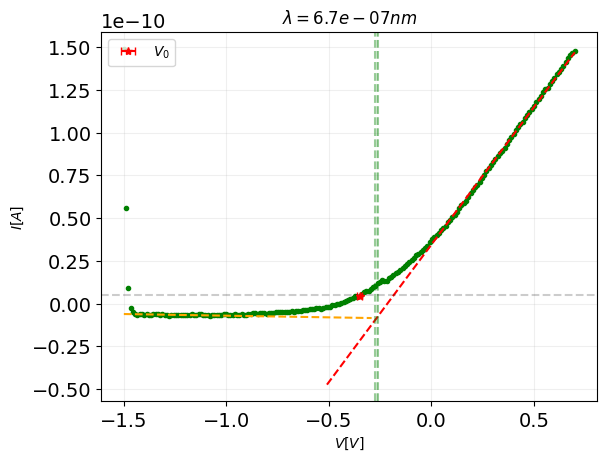

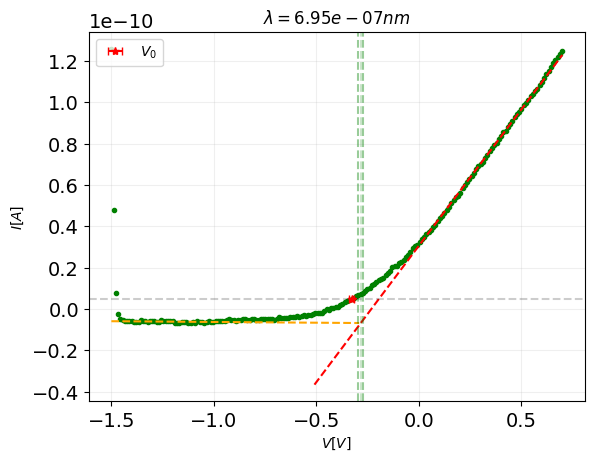

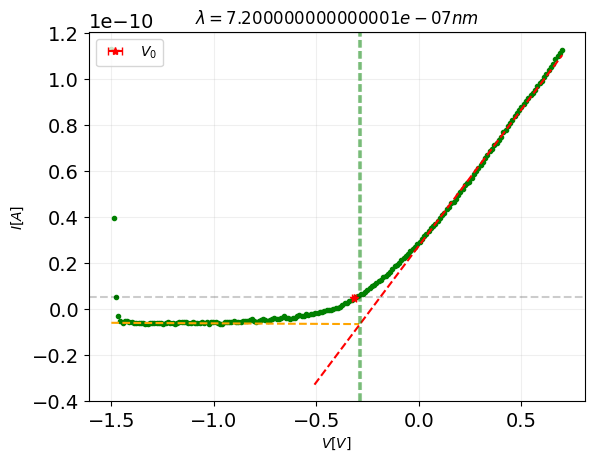

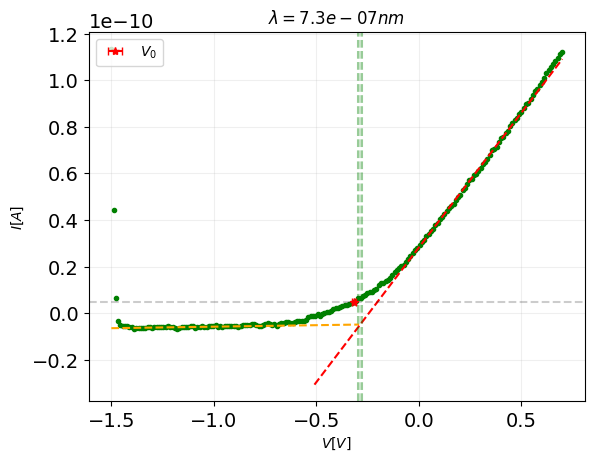

In [111]:
N = len(X)
V0, err_V0, Xc0 = np.zeros((3, N))
V0C, err_V0C = np.zeros((2, N))

ep0 = .05e-10
for k in range(len(X)):
    # ----Calculamos ambos criterios----
    Xc0[k], V0[k], err_V0[k] = V0min(-X[k], V[k])
    p0, p1, V0C[k], err_V0C[k] = rectas(-X[k], V[k])
        
    #---Calculo de las rectas-----
    f = lambda x, a, b: a * x + b
    v_sim = np.linspace(V[k][0], V[k][-1], 1000)

    #----Gráficos----
    plt.figure()
    
    plt.plot(V[k], -X[k], '.', color = 'green'), plt.plot()
    plt.plot(v_sim[:-450], f(v_sim, *p0)[:-450], '--', color = 'orange')
    plt.plot(v_sim[450:], f(v_sim, *p1)[450:], '--', color = 'red')

    plt.errorbar(V0[k], Xc0[k], fmt = '*', xerr = err_V0[k], capsize = 3, 
                    linestyle = 'None', color = 'red', label = r'$V_0$') #-->Puntos de corriente nula
    
    plt.axvline(V0C[k], linestyle = '--', color = 'green', alpha = 0.2)
    plt.axvline(V0C[k] + err_V0C[k], linestyle = '--', color = 'green', alpha = 0.4)
    plt.axvline(V0C[k] - err_V0C[k], linestyle = '--', color = 'green', alpha = 0.4)
    
    plt.axhline(ep0, linestyle = '--', color = 'black', alpha = 0.2)
    
    plt.xlabel(r'$V \left[V\right]$'), plt.ylabel(r'$I \left[A\right]$'), plt.title(rf'$\lambda = {c/nu[k]} nm$')
    plt.grid(alpha = 0.2), plt.legend(loc = 'upper left')
    plt.show()

### Figura para el informe

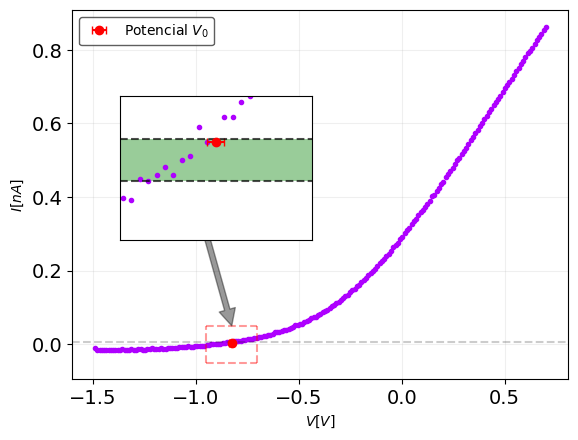

In [112]:
#-------Tomo dato N de las mediciones---------
k = 0

#----Gráficos----

#---------------
# Figura main
#---------------
fig, main_ax = plt.subplots()

main_ax.plot(V[k][1:], -X[k][1:] * 1e9, '.', color = "#ae00ff") # --> eliminé el primer punto

main_ax.errorbar(V0[k], Xc0[k] * 1e9, fmt = 'o', xerr = err_V0[k], capsize = 3, 
                linestyle = 'None', color = 'red', label = r'Potencial $V_0$') #-->Puntos de corriente nula

main_ax.axhline(ep0 * 1e9, linestyle = '--', color = 'black', alpha = 0.2)

main_ax.set(xlabel = r'$V \left[V\right]$', ylabel = r'$I \left[nA\right]$')
main_ax.grid(alpha = 0.2), main_ax.legend(loc = 'upper left', edgecolor = "#36363600")


#---------------
# Caja del zoom
#---------------
main_ax.plot([-.7]*2, [-.05, .05], color = 'red', linestyle = '--', alpha = .4) # --> Barra derecha
main_ax.plot([-.95]*2, [-.05, .05], color = 'red', linestyle = '--', alpha = .4) # --> Barra izquierda
main_ax.plot([-.95, -.7], [-.05]*2, color = 'red', linestyle = '--', alpha = .4) # --> Barra abajo
main_ax.plot([-.95, -.7], [.05]*2, color = 'red', linestyle = '--', alpha = .4) # --> Barra arriba

#---------
# Flecha
#---------
main_ax.annotate('', xy = (np.mean([-.95, -.7]), .05), xytext = (-1, .4),
                 arrowprops = dict(facecolor = 'black', alpha = 0.4))

#-------------
# Figura zoom
#-------------
zoom_ax = fig.add_axes([.2, .4, .3, .3], facecolor = 'white')

zoom_ax.plot(V[k][1:], -X[k][1:], '.', color = "#ae00ff")
zoom_ax.errorbar(V0[k], Xc0[k], fmt = 'o', xerr = err_V0[k], capsize = 3, 
                linestyle = 'None', color = 'red', label = r'$V_0$')

zoom_ax.axhline(ep0, linestyle = '--', color = 'black', alpha = 0.7)
zoom_ax.axhline(0, linestyle = '--', color = 'black', alpha = 0.7)

zoom_ax.set(xticks = [], yticks = [], 
            ylim = (-.7e-11, 1e-11), xlim = (-.95, -.7))

zoom_ax.fill_between(np.arange(-1, -.4, 0.01), 0, ep0, facecolor = 'green', alpha = 0.4)

plt.savefig(dir_drive + 'Figuras_informe/420nm_medicion.pdf', bbox_inches = 'tight')
plt.show()

# Gráficos de ajuste

Función de ajuste:
$eV_0 = h \nu - \hat{\phi}$

12
288.035581371348 0.0
Método visual : 3.3301575032348513e-34 +- 5.003998556287822e-36
Método rectas : 8.404985524648144e-35 +- 1.722546716978497e-35


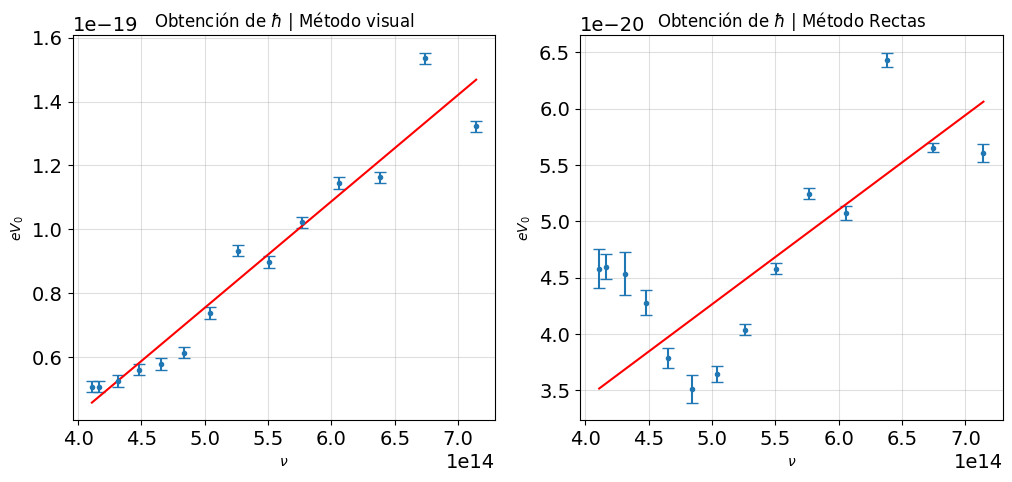

In [113]:
# Defino e y paso a arrayos
elect = -1.60217663e-19 #C
V0, err_V0 = np.array(V0), np.array(err_V0)
V0C, err_V0C = np.array(V0C), np.array(err_V0C)
nu = np.array(nu)

# ------------Ajuste lineal------------
f = lambda x, a, c: a * x + c

# --> Ajuste para método visual
popt, pcov = curve_fit(f, nu, elect*V0, sigma = elect*err_V0, p0 = [6e-34, 1.4e-19], absolute_sigma = True)
h, err_h = popt[0], np.sqrt(np.diag(pcov))[0]

#chi2
df = N - 2
print(df)
Chi2 = sum( ( (elect*V0 - f(nu, *popt)) / (elect*err_V0) )**2 )
p_valor = 1 - chi2(df = df).cdf(Chi2)
print(Chi2, p_valor)

# --> Ajuste para método por rectas
poptC, pcovC = curve_fit(f, nu, elect*V0C, sigma = elect*err_V0C)
hC, err_hC = poptC[0], np.sqrt(np.diag(pcovC))[0]


# -----------Gráfico de ajustes----------
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

# ---> Método visual
axs[0].errorbar(nu, elect*V0, fmt = '.', yerr = -elect*err_V0, capsize = 4)
axs[0].plot(nu, f(np.array(nu), *popt), color = 'red')
axs[0].set(title = r'Obtención de $\hbar$ | Método visual', ylabel = r'$eV_0$', xlabel = r'$\nu$')
axs[0].grid(alpha = 0.4)

# ---> Método rectas
axs[1].errorbar(nu, elect*V0C, fmt = '.', yerr = -elect*err_V0C, capsize = 4)
axs[1].plot(nu, f(np.array(nu), *poptC), color = 'red')
axs[1].set(title = r'Obtención de $\hbar$ | Método Rectas', ylabel = r'$eV_0$', xlabel = r'$\nu$')
axs[1].grid(alpha = 0.4)

print(f'Método visual : {h} +- {err_h}')
print(f'Método rectas : {hC} +- {err_hC}')


### Figura para el informe

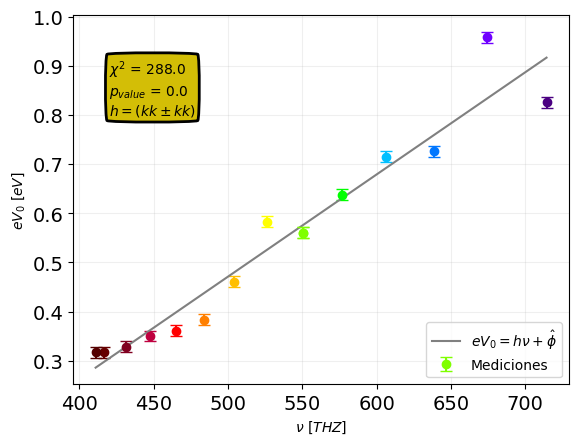

In [114]:
#-----Lista de colores------
colores = [
    '#4b0082',  # 420 nm, violeta
    '#6f00ff',  # 445 nm, azul violeta
    '#0077ff',  # 470 nm, azul
    '#00bfff',  # 495 nm, azul verdoso
    '#00ff00',  # 520 nm, verde
    '#7fff00',  # 545 nm, verde amarillento
    '#ffff00',  # 570 nm, amarillo
    '#ffbf00',  # 595 nm, amarillo-naranja
    '#ff7f00',  # 620 nm, naranja
    '#ff0000',  # 645 nm, rojo
    '#bf003f',  # 670 nm, rojo profundo
    '#800020',  # 695 nm, rojo oscuro
    '#660000',  # 720 nm, rojo muy oscuro
    '#550000',  # 730 nm, casi infrarrojo
]

fig, axs = plt.subplots()

#-----------------
# Figura principal
#-----------------
for n in range(len(nu)):
    axs.errorbar(nu[n] * 1e-12, elect*V0[n] * 6.242e+18, color = colores[n], 
             fmt = 'o', capsize = 4, yerr = -elect*err_V0[n]*6.242e+18) #--> Pase de Joules a ev y Hz a THz

axs.plot(nu * 1e-12, f(nu, *popt) * 6.242e+18, '-', color = 'gray', label = r'$eV_0 = h\nu + \hat{\phi}$')

axs.errorbar(nu[5] * 1e-12, elect*V0[5] * 6.242e+18, color = colores[5], 
             fmt = 'o', capsize = 4, yerr = -elect*err_V0[5]*6.242e+18, 
             alpha = 1, label = 'Mediciones')

axs.set(ylabel = r'$eV_0$ $[eV]$', xlabel = r'$\nu$ $[THZ]$')
axs.grid(alpha = 0.2), axs.legend(loc = 'lower right')

#--------------
# Caja con info
#--------------
bbox = {
    'boxstyle': 'round4',
    'facecolor': "#D3BE06",
    'edgecolor': 'black',
    'linewidth': 2
}
texto = r'$\chi^2$ = ' + f'{np.round(Chi2)}\n' + r'$p_{value}$ = ' + f'{p_valor}\n' + r'$h = (kk \pm kk)$'
axs.annotate(texto, xy = (420, 0.8), bbox = bbox)

plt.savefig(dir_drive + 'Figuras_informe/ajuste_h.pdf', bbox_inches = 'tight')
plt.show()

## Barrido de longitudes (dia 3)

### Cargamos los datos

In [115]:
df = pd.read_csv(dir_drive + 'Mediciones/Barrido de longitudes/medicion_completa.csv')
long_ond = np.array(df['long']) / 1e9 # m
I_5v, nu_odna = -df['X'], c / long_ond

### Usamos criterios de selección

In [116]:
# Busco los valores
nus = nu_odna[(nu_odna <= 4.25e14) & (nu_odna >= 4e14)]
Is = I_5v[(nu_odna <= 4.25e14) & (nu_odna >= 4e14)]

# Tomo promedios y como error la mayor distancia
nu0= np.mean(nus)
err_nu0 = np.max([nu0 - nus[0], nus[-1] - nu0])

### Gráfico

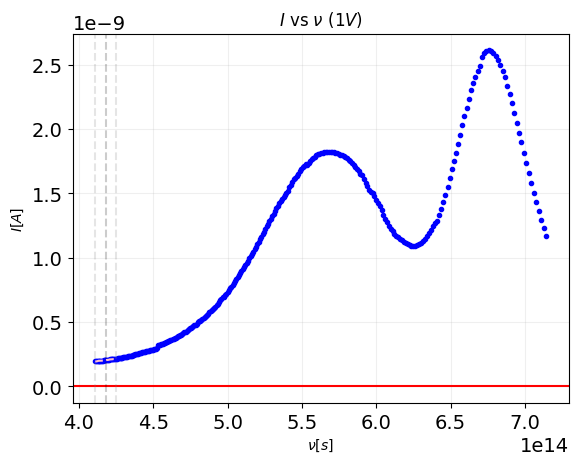

In [117]:
plt.figure()

plt.plot(nu_odna, I_5v, '.', color = 'blue'), plt.axhline(0, color = 'red')
plt.plot(nus, Is, '--', color = 'pink')

plt.axvline(nu0, linestyle = '--', color = 'black', alpha = 0.2)
plt.axvline(nu0 + err_nu0, linestyle = '--', color = 'gray', alpha = 0.2)
plt.axvline(nu0 - err_nu0, linestyle = '--', color = 'gray', alpha = 0.2)

plt.title(r'$I$ vs $\nu$ $(1V)$'), plt.ylabel(r'$I[A]$'), plt.xlabel(r'$\nu[s]$')
plt.grid(alpha = 0.2)
plt.show()

In [118]:
# Calculos del potencial
pot, err_pot = nu0 * h, np.sqrt(nu0 * err_nu0**2 + h * err_h**2)

print(pot, err_pot)

1.3915710882624562e-19 1.4431392399544238e+20
